## ECE495 Lab2: Krichmar Path Planning using Nengo

This Lab uses Nengo to find the optimal path of a square or rectangular map using Krichmar's spike-wave propagation algorithm. The objectives of this lab are to:
- Implement Krichmar's spike-wave propagation algorithm using Nengo neurons
- Ensure the spike wave works for any rectangular or square map
- Utilize an "off-chip" AER to compute the fastest route to get from any starting point (location) to any ending point (location)

_Note: This is your assignment description and a proposed outline by which you can complete your assignment_
- The assignment is worth 60 points
- You may hardcode your connections for each of the three required maps _for a max score of 50/60_
- _**Be sure to print your final path for each map or save it somewhere in your repository so that I can check your work!**_

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [144]:
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import Piecewise
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2

### Input Maps

Check that your spike-wave propagation and AER work for these three maps:
 
(a) The following $3 \times 3$ array with start location 0 (top left) and end location 8 (bottom right). 
$$\begin{bmatrix} 1 & 2 & 1 \\
                  1 & 3 & 5 \\
                  7 & 1 & 1
                      \end{bmatrix}$$

(b) The following $3 \times 4$ array with start location 0 and end location 11.
$$\begin{bmatrix} 1 & 2 & 1 & 6 \\
                  1 & 3 & 5 & 3 \\
                  7 & 1 & 4 & 1
                      \end{bmatrix}$$

(c) The following $5 \times 5$ array with start location 10 and end location 4.
$$\begin{bmatrix} 1 & 3 & 7 & 2 & 1\\
                  3 & 1 & 5 & 3 & 1\\
                  3 & 2 & 6 & 1 & 2\\
                  3 & 1 & 5 & 6 & 1\\
                  2 & 2 & 1 & 1 & 2
                      \end{bmatrix}$$


In [145]:
# input1 = np.array([[1,2,1], [1,3,5], [7,1,1]])
# starti = 0
# startj = 0
# endi = 2
# endj = 2
# start1D = 0
# end1D = 8

# input1 = np.array([[1,2,1,6], [1,3,5,3], [7,1,4,1]])
# starti = 0
# startj = 0
# endi = 2
# endj = 3
# start1D = 0
# end1D = 11

input1 = np.array(
    [
        [1, 3, 7, 2, 1],
        [3, 1, 5, 3, 1],
        [3, 2, 6, 1, 2],
        [3, 1, 5, 6, 1],
        [2, 2, 1, 1, 2],
    ]
)
starti = 2
startj = 0
endi = 0
endj = 4
start1D = 10
end1D = 4

### Set up and run your Nengo model to implement the spike-wave propagation
_Be sure to generalize or take the 10 points deduction!_

Hints: 
- Use a piecewise function to kick off the spike wave, then turn off your input and let the wave do the rest. Be sure this input connects to your _start location._
- Use a Nengo Ensemble for each map location (you can use an Ensemble array, a multidimensional ensemble, or a list of ensembles). Every map location has anywhere from 3 (corner locations) to 8 (inside locations) neighbors to which it can send a spike. Be careful with your connections! I personally said each of them had 8 possible locations and then deleted any locations that were "off-map", but do what makes the most sense to you. 
- Create a delay node to emulate an axonal delay from Krichmar's algorithm. Each map location should have a delay equal to the weight (difficulty of traversal) of the location.
- Implementing inhibition is _difficult_! Recall from Krichmar's algorithm that once a map location fires, it should not fire again. If you can't get the inhibition to work, instead try to add another function to your delay node that turns off a map location once it's sent the spike wave forward

In [146]:
model = nengo.Network(label="Lab2 - Wipf")

# Get size of each matrix

with model:

    len1 = len(input1.ravel())
    x1, y1 = np.shape(input1)
    neuron = []
    neurcol = []
    for i in range(0, x1):
        for j in range(0, y1):
            neurcol.append(nengo.Ensemble(n_neurons=100, dimensions=1))
        neuron.append(neurcol)
        neurcol = []


# model = nengo.Network(label="AER")

### Create AER off-neuron
_Pay attention to how Krichmar says he uses the AER to determine the path_  

Hints:
- The AER contains a location and a time of first spike.
- Start at the end location and work backward!
- I found that by looking at the first spike times of all possible neighboring map locations and choosing the smallest time allowed me to work from end node to start node for my optimal path.

In [147]:
# Delays
delayprobearray = []
inputprobearray = []


class Delay:
    def __init__(self, dimensions, timesteps=50):
        self.history = np.zeros((timesteps, dimensions))
        self.startspike = False
        self.stopspike = False

    def step(self, t, x):
        self.history = np.roll(self.history, -1)
        self.history[-1] = x

        if self.history[0] > 0.8:
            self.startspike = True
        if self.history[0] < 0.25 and self.startspike == True:
            self.stopspike = True

        if self.stopspike == True:
            return 0
        else:
            return self.history[0]


dt = 0.001  # default nengo timestep

with model:
    len2 = len(input1.ravel())
    x1, y1 = np.shape(input1)
    delaynode = []
    delcol = []
    for i in range(0, x1):
        for j in range(0, y1):
            delay = Delay(1, timesteps=int(input1[i][j] / dt))
            delcol.append(nengo.Node(delay.step, size_in=1, size_out=1))
        delaynode.append(delcol)
        delcol = []

with model:

    inp_node = nengo.Node(Piecewise({0: 1, 0.25: 0}))  # quick spike into start node
    neuron_probe = nengo.Probe(inp_node, synapse=0.01)
    nengo.Connection(inp_node, delaynode[starti][startj])

    for i in range(0, x1):
        for j in range(0, y1):
            nengo.Connection(delaynode[i][j], neuron[i][j])
            # top left
            if i == 0 and j == 0:
                nengo.Connection(neuron[i][j], delaynode[i][j + 1])
                nengo.Connection(neuron[i][j], delaynode[i + 1][j])
                nengo.Connection(neuron[i][j], delaynode[i + 1][j + 1])
            # top right
            elif i == 0 and j == (len(neuron[i]) - 1):
                nengo.Connection(neuron[i][j], delaynode[i][j - 1])
                nengo.Connection(neuron[i][j], delaynode[i + 1][j - 1])
                nengo.Connection(neuron[i][j], delaynode[i + 1][j])
            # bottom left
            elif i == (len(neuron) - 1) and j == 0:
                nengo.Connection(neuron[i][j], delaynode[i - 1][j])
                nengo.Connection(neuron[i][j], delaynode[i - 1][j + 1])
                nengo.Connection(neuron[i][j], delaynode[i][j + 1])
            # bottom right
            elif i == (len(neuron) - 1) and j == (len(neuron[i]) - 1):
                nengo.Connection(neuron[i][j], delaynode[i - 1][j])
                nengo.Connection(neuron[i][j], delaynode[i - 1][j - 1])
                nengo.Connection(neuron[i][j], delaynode[i][j - 1])
            # top row
            elif i == 0:
                nengo.Connection(neuron[i][j], delaynode[i][j - 1])
                nengo.Connection(neuron[i][j], delaynode[i + 1][j - 1])
                nengo.Connection(neuron[i][j], delaynode[i + 1][j])
                nengo.Connection(neuron[i][j], delaynode[i][j + 1])
                nengo.Connection(neuron[i][j], delaynode[i + 1][j + 1])
            # bottom row
            elif i == (len(neuron) - 1):
                nengo.Connection(neuron[i][j], delaynode[i - 1][j - 1])
                nengo.Connection(neuron[i][j], delaynode[i][j - 1])
                nengo.Connection(neuron[i][j], delaynode[i - 1][j])
                nengo.Connection(neuron[i][j], delaynode[i - 1][j + 1])
                nengo.Connection(neuron[i][j], delaynode[i][j + 1])
            # left col
            elif j == 0:
                nengo.Connection(neuron[i][j], delaynode[i - 1][j])
                nengo.Connection(neuron[i][j], delaynode[i - 1][j + 1])
                nengo.Connection(neuron[i][j], delaynode[i][j + 1])
                nengo.Connection(neuron[i][j], delaynode[i + 1][j + 1])
                nengo.Connection(neuron[i][j], delaynode[i + 1][j])

            # right col
            elif j == (len(neuron[i]) - 1):
                nengo.Connection(neuron[i][j], delaynode[i - 1][j - 1])
                nengo.Connection(neuron[i][j], delaynode[i - 1][j])
                nengo.Connection(neuron[i][j], delaynode[i][j - 1])
                nengo.Connection(neuron[i][j], delaynode[i + 1][j - 1])
                nengo.Connection(neuron[i][j], delaynode[i + 1][j])

            # middle
            else:
                nengo.Connection(neuron[i][j], delaynode[i - 1][j - 1])
                nengo.Connection(neuron[i][j], delaynode[i - 1][j])
                nengo.Connection(neuron[i][j], delaynode[i - 1][j + 1])
                nengo.Connection(neuron[i][j], delaynode[i][j - 1])
                nengo.Connection(neuron[i][j], delaynode[i][j + 1])
                nengo.Connection(neuron[i][j], delaynode[i + 1][j - 1])
                nengo.Connection(neuron[i][j], delaynode[i + 1][j])
                nengo.Connection(neuron[i][j], delaynode[i + 1][j + 1])

In [148]:
# Send the delayed output through an ensemble
probearray = []
delayprobearray = []
with model:
    for i in range(0, x1):
        for j in range(0, y1):

            probearray.append(nengo.Probe(neuron[i][j], synapse=0.01))
            delayprobearray.append(nengo.Probe(delaynode[i][j], synapse=0.01))

# Run for 2 seconds
sim_time = 15
with nengo.Simulator(model) as sim:
    sim.run(sim_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

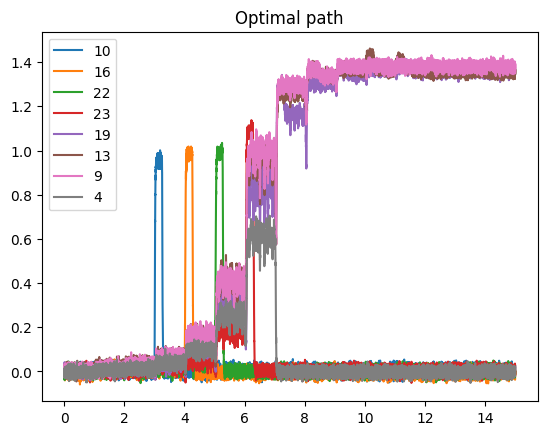

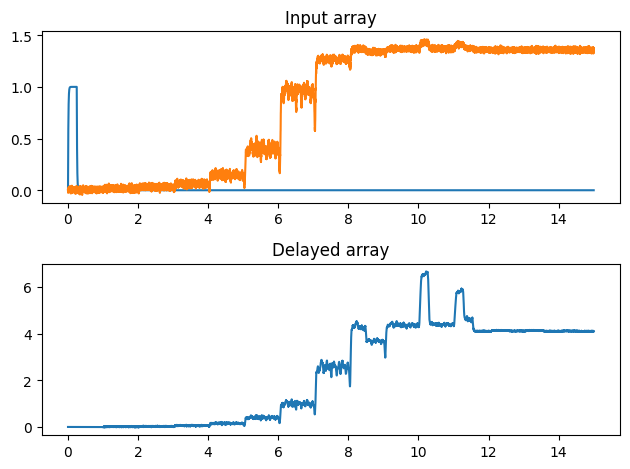

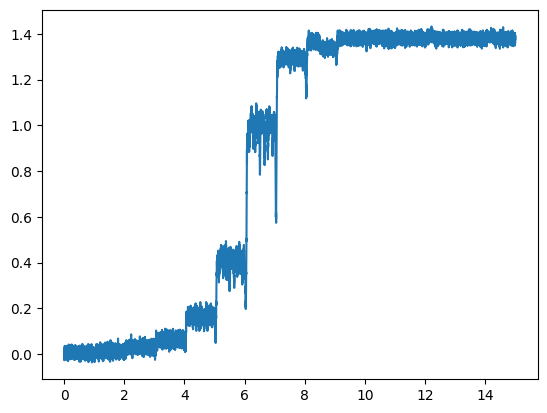

In [149]:
# Plot the results
plt.figure()
plt.plot(sim.trange(), sim.data[probearray[10]], label=10)
plt.plot(sim.trange(), sim.data[probearray[16]], label=16)
plt.plot(sim.trange(), sim.data[probearray[22]], label=22)
plt.plot(sim.trange(), sim.data[probearray[23]], label=23)
plt.plot(sim.trange(), sim.data[probearray[19]], label=19)
plt.plot(sim.trange(), sim.data[probearray[13]], label=13)
plt.plot(sim.trange(), sim.data[probearray[9]], label=9)
plt.plot(sim.trange(), sim.data[probearray[4]], label=4)
plt.title("Optimal path")
plt.legend()
plt.show()


plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[neuron_probe])
plt.title("Input node")

# Plot the results
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[probearray[13]])
plt.title("Input array")

plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[delayprobearray[13]])
plt.title("Delayed array")

plt.tight_layout()

plt.figure()
plt.plot(sim.trange(), sim.data[probearray[9]])

### Print your optimal path
_Be sure to show your results_  

Some options:
- You can print your map locations as x- and y- coordinates (examples: start_loc = [0,0] or [2,0]) or flattened locations (examples: start_loc = 0 or 10)
- You can create a picture of a map (like in Krichmar's paper) where you draw out your final path

In [168]:
# Set up array of time steps
step = 0
finalpath = []
spikelocs = []
firstspike = []
len_probe_array = len(probearray)

for i in range(0, len_probe_array):
    aer = sim.data[probearray[i]][:, 0] > 0.8
    spike = np.where(aer == True)
    if np.asarray(spike).size == 0:
        spikelocs.append(sim_time / dt)
    else:
        spikelocs.append(np.min(spike))

for i in range(0, len_probe_array):
    print("Location ", i, "is: ", spikelocs[i])

two_d_spikelocs = np.reshape(spikelocs, (x1, y1))

finalpath.append([endi, endj])
curr_loc = finalpath[step]

Location  0 is:  5055
Location  1 is:  7055
Location  2 is:  11051
Location  3 is:  7197
Location  4 is:  15000.0
Location  5 is:  6040
Location  6 is:  4042
Location  7 is:  9046
Location  8 is:  15000.0
Location  9 is:  6073
Location  10 is:  3028
Location  11 is:  5041
Location  12 is:  10034
Location  13 is:  6075
Location  14 is:  7071
Location  15 is:  6040
Location  16 is:  4039
Location  17 is:  9045
Location  18 is:  15000.0
Location  19 is:  6115
Location  20 is:  6050
Location  21 is:  6050
Location  22 is:  5049
Location  23 is:  6056
Location  24 is:  8059


In [167]:
prev_val = spikelocs[end1D]
# Determine final path
while finalpath[step] != [starti, startj]:
    i = curr_loc[0]
    j = curr_loc[1]

    x = []
    z = []
    min_v = 0

    # top left
    if i == 0 and j == 0:
        x.append(two_d_spikelocs[i + 1][j + 1])
        x.append(two_d_spikelocs[i][j + 1])
        x.append(two_d_spikelocs[i + 1][j])
        for k in range(0, len(x)):
            if x[k] != prev_val:
                z.append(x[k])
            else:
                prev_val = x[k]
        min_v = min(z)
        y = np.where(two_d_spikelocs == min_v)
        finalpath.append([int(y[0]), int(y[1])])
        step += 1
    # top right
    elif i == 0 and j == (y1 - 1):
        x.append(two_d_spikelocs[i][j - 1])
        x.append(two_d_spikelocs[i + 1][j - 1])
        x.append(two_d_spikelocs[i + 1][j])
        for k in range(0, len(x)):
            if x[k] != prev_val:
                z.append(x[k])
            else:
                prev_val = x[k]
        min_v = min(z)
        y = np.where(two_d_spikelocs == min_v)
        finalpath.append([int(y[0]), int(y[1])])
        step += 1
    # bottom left
    elif i == (x1 - 1) and j == 0:
        x.append(two_d_spikelocs[i - 1][j])
        x.append(two_d_spikelocs[i - 1][j + 1])
        x.append(two_d_spikelocs[i][j + 1])
        for k in range(0, len(x)):
            if x[k] != prev_val:
                z.append(x[k])
            else:
                prev_val = x[k]
        min_v = min(z)
        y = np.where(two_d_spikelocs == min_v)
        finalpath.append([int(y[0]), int(y[1])])
        step += 1
    # bottom right
    elif i == (x1 - 1) and j == (y1 - 1):
        x.append(two_d_spikelocs[i - 1][j - 1])
        x.append(two_d_spikelocs[i - 1][j])
        x.append(two_d_spikelocs[i][j - 1])
        for k in range(0, len(x)):
            if x[k] != prev_val:
                z.append(x[k])
            else:
                prev_val = x[k]
        min_v = min(z)
        y = np.where(two_d_spikelocs == min_v)
        finalpath.append([int(y[0]), int(y[1])])
        step += 1
    # top row
    elif i == 0:
        x.append(two_d_spikelocs[i][j - 1])
        x.append(two_d_spikelocs[i + 1][j - 1])
        x.append(two_d_spikelocs[i + 1][j])
        x.append(two_d_spikelocs[i + 1][j + 1])
        x.append(two_d_spikelocs[i][j + 1])
        for k in range(0, len(x)):
            if x[k] != prev_val:
                z.append(x[k])
            else:
                prev_val = x[k]
        min_v = min(z)
        y = np.where(two_d_spikelocs == min_v)
        finalpath.append([int(y[0]), int(y[1])])
        step += 1
    # bottom row
    elif i == (x1 - 1):
        x.append(two_d_spikelocs[i - 1][j - 1])
        x.append(two_d_spikelocs[i][j - 1])
        x.append(two_d_spikelocs[i - 1][j])
        x.append(two_d_spikelocs[i - 1][j + 1])
        x.append(two_d_spikelocs[i][j + 1])
        for k in range(0, len(x)):
            if x[k] != prev_val:
                z.append(x[k])
            else:
                prev_val = x[k]
        min_v = min(z)
        y = np.where(two_d_spikelocs == min_v)
        finalpath.append([int(y[0]), int(y[1])])
        step += 1
    # left col
    elif j == 0:
        x.append(two_d_spikelocs[i - 1][j])
        x.append(two_d_spikelocs[i - 1][j + 1])
        x.append(two_d_spikelocs[i][j + 1])
        x.append(two_d_spikelocs[i + 1][j + 1])
        x.append(two_d_spikelocs[i + 1][j])
        for k in range(0, len(x)):
            if x[k] != prev_val:
                z.append(x[k])
            else:
                prev_val = x[k]
        min_v = min(z)
        y = np.where(two_d_spikelocs == min_v)
        finalpath.append([int(y[0]), int(y[1])])
        step += 1
    # right col
    elif j == (y1 - 1):
        x.append(two_d_spikelocs[i - 1][j - 1])
        x.append(two_d_spikelocs[i - 1][j])
        x.append(two_d_spikelocs[i][j - 1])
        x.append(two_d_spikelocs[i + 1][j - 1])
        x.append(two_d_spikelocs[i + 1][j])
        for k in range(0, len(x)):
            if x[k] != prev_val:
                z.append(x[k])
            else:
                prev_val = x[k]
        min_v = min(z)
        y = np.where(two_d_spikelocs == min_v)
        finalpath.append([int(y[0]), int(y[1])])
        step += 1
    # else
    else:
        x.append(two_d_spikelocs[i - 1][j - 1])
        x.append(two_d_spikelocs[i - 1][j])
        x.append(two_d_spikelocs[i - 1][j + 1])
        x.append(two_d_spikelocs[i][j - 1])
        x.append(two_d_spikelocs[i][j + 1])
        x.append(two_d_spikelocs[i + 1][j - 1])
        x.append(two_d_spikelocs[i + 1][j])
        x.append(two_d_spikelocs[i + 1][j + 1])
        for k in range(0, len(x)):
            if x[k] != prev_val:
                z.append(x[k])
            else:
                prev_val = x[k]
        min_v = min(z)
        y = np.where(two_d_spikelocs == min_v)
        finalpath.append([int(y[0]), int(y[1])])
        step += 1
    curr_loc = [int(y[0]), int(y[1])]


def reverse_outer_arrays(array):
    reversed_array = []
    for i in reversed(range(len(array))):
        reversed_array.append(array[i])
    return reversed_array


print("Final path:", reverse_outer_arrays(finalpath))

C:\Users\cadet_admin\AppData\Local\Temp\ipykernel_11660\3634522445.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  finalpath.append([int(y[0]),int(y[1])])
C:\Users\cadet_admin\AppData\Local\Temp\ipykernel_11660\3634522445.py:150: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  curr_loc = [int(y[0]), int(y[1])]
C:\Users\cadet_admin\AppData\Local\Temp\ipykernel_11660\3634522445.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  finalpath.append([int(y[0]),int(y

KeyboardInterrupt: 